# analyzing sequence data with transformers

In this jupyter notebook, we'll build a 'transformer' network to classify data samples from sequence data.

For this exercise, we want to focus on building the network, so we'll just analyze some simulated data. We'll use scikit-learn to simulate sequence data using the make_classification function, like we did before.

The following data-simulation code cell should look pretty familiar. Lines 6-9 simulate 38,262 data samples of 128 sequence 'features' or 'items', 32 of which are correlated with the binary class labels. Line 10 splits the simulated data into 80% training and 20% validation sub-sets, and we print the 'shapes' of the resulting data on lines 11 and 12.

Lines 15-17 are where things get a bit different.

In a 'typical' sequence model, the model itself keeps track of 'where' an item is in the sequence; this is true of both Conv1D and LSTM (or other recurrent network) models. In these cases, we don't need to 'encode' the location of each item in the sequence data.

Transformer models are different; they do *not* keep track of the location of each item in the sequence. Rather, transformer models process *each* item in the sequence in *exactly the same way*. So, if the location of each item in the sequence is not encoded in the sequence data, the transformer will *not* make use of data 'locality' when it analyzes the sequence data.

Lines 15-17 are where we 'encode' the sequence location information as part of the training and validation data.

There are 'fancier' ways to encode sequence location information, but in our case, we're just going to encode the location of each item in the sequence as a floating-point number between -2.0 (the *first* item in the sequence) and +2.0 (the *last* item in the sequence).

To do this, we first need to create a vector with evenly-spaced numbers between -2.0 and +2.0, one for each of the items in our sequence. We simulated sequence data with 128 'features', so we need to create a vector with 128 evenly-spaced numbers between -2.0 and +2.0.

The numpy function:

    np.linspace(...)

is used to create a vector of evenly-spaced numbers between some starting value and some ending value. So, we can just specify -2.0 as the starting value, +2.0 as the ending value, and 128 as the number of values to create in the vector:

    np.linspace(start=-2.0, stop=+2.0, num=128)

This will create a vector that looks something like:

    [ -2.00, -1.97, -2.94, ..., 1.94, 1.97, 2.00 ]

with some rounding error.

Now we want to 'connect' the location vector to our existing sequence data, so that the first item in the sequence gets -2.00 'attached' to it, the second item gets value -1.97, etc.

Basically, we have sequence data that looks like:

    [ a, b, c, ... ]

and location data that looks like:

    [ -2.00, -1.97, -1.94, ... ]

and we want to 'combine' them to create a new sequence that looks like:

    [ [a, -2.00], [b, -1.97], [c, -1.94], ... ]

We can use the numpy function "stack" to combine the sequence data with the location data, but *first* we need to generate the appropriate number of replicated location vectors, one for each 'row' in the data set.

To replicate the location vector, we just call:

    np.array([loc] * count)

Which will create a new numpy 'array' with the values in 'loc' replicated 'count' number of times. But how many times do we need to 'replicate' the location data?

We've already split our sequence data into training (train_x) and validation (valid_x) sub-sets, so we'll need to create *two* different-sized location arrays, one with the same number of 'rows' as the training data, and one with the same number of 'rows' as the validation data. We can get the number of 'rows' of the training data by accessing:

    train_x.shape[0]

Which extracts the dimensionality of the *first* rank of the train_x.shape tuple, which is the number of 'rows' in the train_x data set.

So, to create a location array with the location vector replicated the *same* number of times as there are rows in the train_x data set, we just call:

    np.array([loc] * train_x.shape[0])

We can then 'stack' this location array onto the existing train_x data set, using the "np.stack(...)" function call. We need to make sure we specify that we want the *last* ranks of the arrays (technically, tensors) stacked, so we'll need to set axis=-1:

    np.stack( [ array1, array2 ], axis=-1)

Filling in the appropriate 'values' for "array1" and "array2":

    np.stack( [ train_x, np.array([loc]*train_x.shape[0]) ], axis=-1)

On line 16, we use this code to create a new train_x data set that includes location information. And on line 17, we do the same thing to 'update' the valid_x data set. Now we have training and validation data that includes *both* the original sequence data *and* an encoding of the 'location' of each item in the sequence.

You can see that we've increased the dimensionality of the last rank of the training (and validation) data by 1, and we print the validation data, so you can see that each item has both sequence data *and* the location information attached to it.

In [ ]:
import numpy as np
import sklearn.datasets
import sklearn.model_selection

# generate sequence data
x, y = sklearn.datasets.make_classification(n_samples=38262,
                                            n_features=128,
                                            n_informative=32,
                                            random_state=8792439)
train_x, valid_x, train_y, valid_y = sklearn.model_selection.train_test_split(x,y, test_size=0.2, random_state=849691)
print(train_x.shape, valid_x.shape)
print(train_y.shape, valid_y.shape)

# add 'location' to sequence data
loc = np.linspace(start=-2.0, stop=+2.0, num=128)
train_x = np.stack([ train_x, np.array([loc]*train_x.shape[0]) ], axis=-1)
valid_x = np.stack([ valid_x, np.array([loc]*valid_x.shape[0]) ], axis=-1)

print(train_x.shape, valid_x.shape)
print(valid_x)

Now we have our sequence data, with location information appropriately encoded.

As always, it's pretty easy to 'package' our data for tensorflow:

In [ ]:
import tensorflow as tf

train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(32)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y)).batch(32)
print(train_data, valid_data)

## building a transformer

Transformer networks are not 'mind-blowingly' complicated, but compared to the very simple feed-forward networks we've been building, transformers are a bit more complex.

Let's take a look at the basic architecture of a 'transformer':

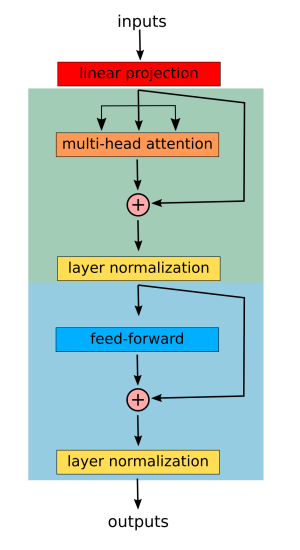

Before the input data is sent to the 'transformer' block, we perform a linear projection of the data into a basic 'representational space' of a specified dimension. This is indicated by the red neural-network layer labelled "linear projection", which is typically implemented as a Dense neural-network layer. This pointwise linear projection simply projects the data (including location information) into whatever dimensionality we specify as the 'representational space' for our sequence data. The only real 'requirement' is that this representational space must match the representational space used by the multi-head attention system and the feed-forward system used later on in the transformer.

It's up to the network designer to 'decide' what internal representation dimensionality to use. For a simple sequence model, we might use a 'small' dimensionality of 4 or 8. For more 'complex' problems like natural language processing, we might use very high-dimensional representations, like 256 or 512. Note that the neural network will 'learn' the pointwise linear projection of the data into this representational space.

The 'transformer' building-block has 2 main components, highlighted in green and blue, respectively. 

The first component (green) includes the multi-head attention layer, but it looks like there are some other 'weird' bits in there that we haven't seen before.

First, notice that the output of the linear-projection layer is split into 3 replicated pieces, before sending the data to the multi-head attention layer. This 3-way 'split' is required to use the *same* (projected) sequence data for the queries, keys and values required by multi-head attention.

The multi-head attention layer produces a single output, but notice that 'weird' arrow that goes from the linear-projection layer's output *around* the multi-head attention layer! That arrow that *bypasses* the multi-head attention layer is called a "residual connection". The residual connection represents a *second* path that the information will travel through the network. The output of the linear-projection layer is sent to the multi-head attention layer, but it is *also* replicated and sent *around* the multi-head attention layer.

After multi-head attention produces its output, this output is *combined* with the residual connection via pointwise addition, which is indicated by the pink circle with the "+" sign in it.

These 'residual' connections are common features of many neural network architectures. They help prevent vanishing-gradient problems in deep networks, and they allow neural-network layers to focus more on calculating 'additional' information that can be 'combined' with the input data, rather than requiring each layer in the network to both 'maintain' the current state of the information *and* calculate additional information that might be relevant for classification.

Operationally, the presence of residual connections means that our transformer network is *not* a simple feed-forward network. So, we can no longer use the simple Sequential model in tensorflow to implement our transformer. We'll need to use the more complicated "functional api" to implement our transformer. We'll get to that a bit later on.

Following the residual connection, the transformer architecture applies "layer normalization", which normalizes the output sequences to have mean close to zero and variance close to one. I've never seen a strong justification for using layer normalization in transformers, but layer normalization has been part of the transformer design since the original 2017 paper, although there is [this work](https://arxiv.org/pdf/2002.04745.pdf) suggesting that applying layer normalization *before* multi-head attention might be preferable. In our network, we'll use the 'original' post-residual layer normalization method.

Okay, so that takes care of the multi-head attention 'block' in the network (shown in green in the above figure).

The second 'block' in the transformer architecture is the "feed-forward" block (highlighted in blue), which consists of a "feed-forward" layer, with the *same* residual connection and layer normalization as was applied with the multi-head attention block.

The "feed-forward" layer is simply 2 Dense neural-network layers, with ReLU activation in between. This will be 'easy' to  implement in tensorflow. 

## implementing the transformer in tensorflow

To implement the transformer in tensorflow, we'll need to abandon the simple Sequential model and use the 'functional api' to create a more complicated model that can have 3-way splits (for input to the multi-head attention layers) and 'residual' connections.

The tensorflow 'functional api' is just a programming mechanism for 'connecting' neural-network layers. "API" stands for Application Programming Interface, a general term used to describe a 'specification' for how to program something in a computer. Tensorflow uses the term "functional api" to describe this particular system, because it effectively uses Layer objects *as if* they were python *functions*.

In python, we can 'call' a function by specifying:

    function_name(inputs)

We provide the name of the function, followed by "(", and then list the inputs to the function, followed by ")". We can also 'capture' the *output* of the function like so:

    output = function_name(inputs)

The tensorflow 'functional api' uses a similar 'syntax' to connect neural-network Layer objects together:

    output_layer = layer_specification()(input_layers)

Here, we create a new Layer object using:

    layer_specification()

At the same time, we set the "input_layers" to the newly-created layer, and 'capture' the resulting output in the "output_layer" variable. It'll probably make a bit more sense once we get going.

To get the network started, we *first* need to create a special Input object that will hold the input to the entire network. This Input object is *not* a Layer, it's a tf.keras.Input object. To create such an object, we just need to specify its shape:

    inlayer = tf.keras.Input(shape=XX)

The "shape" option for the tf.keras.Input object is similar to the "input_shape" option we've been using for the first layer in our Sequential models. 

In our case, our data have shape (128,2), so we'll need to specify:

    inlayer = tf.keras.Input(shape=(128,2))

to create the Input for our functional model.

Next, we need to implement the linear-projection layer, which will 'project' our data up into whatever representational space we want.

Let's first define the dimensionality of our representational space:

    repdim = 4

Then we can use a Dense layer to perform the linear projection:

    proj = tf.keras.layers.Dense(units=repdim)(inlayer)

Notice that the layer specification is just creating a Dense layer with "repdim" units:

    tf.keras.layers.Dense(units=repdim)

where repdim=4, in our case.

But then, we 'connect' this Dense layer to our Input object by appending the:

    (inlayer)

code to the end of our layer specification, so the new Dense layer will take the "inlayer" Input we just created as *input*.

Finally, we capture the *output* of our new Dense layer in the variable "proj", so we can use it later on as *input* to other layers in the network.

### the multi-head attention (mha) block

Tensorflow implements a multi-head attention layer as a tf.keras.layers.MultiHeadAttention object. When creating the layer, we need to specify the number of attention heads (num_heads) and the dimensionality of the keys (key_dim). In our case, we are using "repdim" as the variable to hold the dimensionality of our model's internal data representation, so we can set:

    key_dim=repdim

We'll also set:

    num_heads=1

for now, so we'll just be using a *single* attention head.

The entire specification for our multi-head attention layer is:

    tf.keras.layers.MultiHeadAttention(num_heads=1, key_dim=repdim)

But we still need to specify the *inputs* to the MultiHeadAttention layer. Remember that multi-head attention layers require 3 inputs: queries, keys and values. In a 'typical' scenario, we'll use the *same* data for all 3 multi-head attention inputs.

In our case, the *output* of the *previous* layer in the network has been 'captured' in the variable "proj", which is the output produced from our linear-projection layer. So, we can specify the *input* to our MultiHeadAttention layer like:

    (proj,proj,proj)

which 'replicates' the "proj" output 3 times, producing queries, keys and values that are all the same. Finally, we'll need to 'capture' the *output* from the multi-head attention layer for later use:

    mha1 = tf.keras.layers.MultiHeadAttention(num_heads=1, key_dim=repdim)(proj,proj,proj)

Now we have the *output* from the MultiHeadAttention layer in "mha1", and we have the *input* to the MultiHeadAttention layer in "proj". Let's create the "residual" connection that *bypasses* the MultiHeadAttention layer.

To create the 'residual' connection, we'll use a tf.keras.layers.Add() layer, which simply performs pointwise-addition along a list of tensors. In our case, we want to add the "proj" tensor to the "mha1" tensor, so we can create the Add layer like:

    res1 = tf.keras.layers.Add()([proj,mha1])

Notice that we use "[" ... "]" to create a 'list' containing the tensors "proj" and "mha1", and then we pass this 'list' as *input* to the Add layer. We capture the *output* of the Add layer in a variable called "res1".

Finally, we want to use a tf.keras.layers.LayerNormalization layer to 'normalize' the output from the multi-head attention block. We'll pass "res1" as the input to the LayerNormalization object, and we'll capture its output in a variable called "nrm1":

    nrm1 = tf.keras.layers.LayerNormalization()(res1)

That's the entire multi-head attention block for our transformer network. For convenience, the code for the entire block is reproduced here:

    # set dimensionality of internal data representation
    repdim = 4

    # input and data projection
    inlayer = tf.keras.Input(shape=(128,2))
    proj = tf.keras.layers.Dense(units=repdim)(inlayer)

    # multi-head attention, residual connection, layer normalization
    # aka - MHA block
    mha1 = tf.keras.layers.MultiHeadAttention(num_heads=1, key_dim=repdim)(proj,proj,proj)
    res1 = tf.keras.layers.Add()([proj, mha1])
    nrm1 = tf.keras.layers.LayerNormalization()(res1)

### the feed-forward block

After the multi-head attention 'block', the transformer architecture uses a "feed-forward block" that consists of a sequence of 2 pointwise linear projections (separated by ReLU nonlinear activation), followed by a residual connection and layer normalization, just like was used in the multi-head attention block.

We already have the *output* of the multi-head attention block stored in the "nrm1" variable.

We need to connect this as *input* to the first of two Dense layers, which will use ReLU nonlinear activation:

    ffa1 = tf.keras.layers.Dense(units=repdim, activation=tf.keras.activations.relu)(nrm1)

Notice that we use the *same* internal data representation dimensionality as before, by setting "units=repdim" in the Dense layer.

Next, we need to create the second Dense layer and connect it to the first:

    ffb1 = tf.keras.layers.Dense(units=repdim)(ffa1)

No nonlinear activation, this time.

Next, create the residual connection bypassing *both* Dense layers:

    res2 = tf.keras.layers.Add()([nrm1,ffb1])

And send the results through a LayerNormalization:

    nrm2 = tf.keras.layers.LayerNormalization()(res2)

Now we have the *output* of the entire feed-forward block stored in "nrm2".

### building the transformer model

Our transformer model still needs an output layer, which will classify sequences using binary class labels. This will be a familiar Flatten layer, followed by a Dense layer with a single unit and sigmoid activation. 

The *output* from the previous feed-forward block is "nrm2", which we'll use as *input* to the Flatten layer. In functional api:

    flt = tf.keras.layers.Flatten()(nrm2)
    outlayer = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid)(flt)

Now we have our complete transformer network specified using the functional api.

The tensorflow functional api specifies the input-output *connections* within our transformer model, but we still need to actually *build* the model in tensorflow.

We'll use a tf.keras.Model object to build our transformer model.

Using the functional api, we just need to specify the "inputs" and the "outputs" of the Model object to build our model.

In our case, the *input* to our entire model is the Input object stored in "inlayer". And the *output* from our entire model is the final classification or 'output' layer, "outlayer". So, we just need to do:

    model = tf.keras.Model(inputs=inlayer, outputs=outlayer)

to build our transformer model.

The following code cell combines all the code snippets to build the transformer model.

In [ ]:
import tensorflow as tf

## build model using functional api
repdim = 4  # set internal data representation dimensionality

# input and linear projection
inlayer = tf.keras.Input(shape=(128,2))
proj = tf.keras.layers.Dense(units=repdim)(inlayer)
# multi-head attention block
mha1 = tf.keras.layers.MultiHeadAttention(num_heads=1, key_dim=repdim)(proj,proj,proj)
res1 = tf.keras.layers.Add()([proj, mha1])
nrm1 = tf.keras.layers.LayerNormalization()(res1)
# feed-forward block
ffa1 = tf.keras.layers.Dense(units=repdim, activation=tf.keras.activations.relu)(nrm1)
ffb1 = tf.keras.layers.Dense(units=repdim)(ffa1)
res2 = tf.keras.layers.Add()([nrm1, ffb1])
nrm2 = tf.keras.layers.LayerNormalization()(res2)
# classification block
flt = tf.keras.layers.Flatten()(nrm2)
outlayer = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid)(flt)

model = tf.keras.Model(inputs=inlayer, outputs=outlayer)
model.summary()

Because this model is *not* Sequential, there is a column on the right of the summary that reports the *inputs* to each layer in the network. Notice, for example, that there are *three* inputs to the multi-head attention layer; they are also all the same. Similarly, you'll see *two* inputs to each of the Add layers, representing the 'residual' connections.

Let's take a look at the parameter counts in this transformer network.

There are 661 total trainable parameters, 513 of which are found in the output or 'decision' layer. So, there are only 148 trainable parameters in the 'transformer' part of the network.

Layer normalization requires 8 parameters, two for *each* of the dimensions in the network's internal data representation. One of these parameters 'centers' the data, and the other 'scales' it.

The Add layers implementing residual connections don't require any trainable parameters; they just perform pointwise addition.

Each of the two Dense layers making up the feed-forward part of the transformer network requires 20 trainable parameters. Let's walk through where these parameters are coming from. The internal data representation has 4 dimensions, so there are 4 input weights to each 'unit' in the Dense layer. Plus 1 bias term for each 'unit'. To maintain the internal data representation dimensionality, we've specified 4 'units' in each Dense layer. So, there are (4+1)*4=20 trainable parameters in each of the Dense layers making up the feed-forward part of the network.

That just leaves the multi-head attention layer, which has 80 trainable parameters. Multi-head attention needs to perform *independent* pointwise linear projections of the queries, keys and values. We've already seen from our analysis of the Dense layers in the feed-forward part of the network that *each* of these will require 20 trainable parameters. So that's 60. Where do the remaining 20 trainable parameters come from?

Multi-head attention layers need to 'combine' the outputs from *each* of the attention 'heads' to produce the layer's final output. The multi-head attention layer does this by first *concatenating* the outputs from *all* the attention heads, and then performing a final *pointwise linear projection* of these results back *down* into the dimensionality of the internal data representation. Our internal data representation is in 4 dimensions, and we are only using a single attention head in this example. So, our multi-head attention layer calculates *another* pointwise linear projection from 4 dimensions into 4 dimensions. We already know this requires 20 trainable parameters, so that's where the 'missing' parameters in our multi-head attention layer are coming from.

If we take a second to look at our transformer network, we see *quite a few* places in which *pointwise linear projections* are calculated:

* First, we project our input data into a high-dimensional representational space using a pointwise linear projection.
* Next, we perform *three* independent pointwise linear projections to calculate the queries, keys and values as input to the multi-head attention later. In tensorflow, these projections are 'hidden' within the MultiHeadAttention object.
* Then, we perform *another* pointwise linear projection to calculate the *output* of the multi-head attention layer, also 'hidden' within the tensorflow MultiHeadAttention object.
* Finally, the feed-forward part of the transformer calculates a sequence of *two* different pointwise linear projections, with ReLU activation in between.

In contrast to what we observe in a typical feed-forward neural network - in which there are *a lot* of nonlinear activations between network layers - in the transformer architecture, there are relatively more *pointwise linear* transformations, with relatively *few* typical nonlinear activations.

Rather, in the transformer architecture, the 'complex' matrix operations performed *inside* the multi-head attention layer provide the *majority* of the 'nonlinearity' in the overall network. 

## testing the transformer network

The following code cell is an end-to-end working transformer network analysis of sequence data, including simulating the data, adding location information, and packaging the data as tensorflow Dataset objects. The transformer network creation is exactly the same as before. We compile the model using BinaryCrossentropy loss and the Adam optimizer, and we fit for 20 epochs.

In [ ]:
import numpy as np
import tensorflow as tf
import sklearn.datasets
import sklearn.model_selection

## simulate and package data
# simulate and split
x, y = sklearn.datasets.make_classification(n_samples=38262,
                                            n_features=128,
                                            n_informative=32,
                                            random_state=8792439)
train_x, valid_x, train_y, valid_y = sklearn.model_selection.train_test_split(x,y, test_size=0.2, random_state=849691)
# add 'location' to sequence data
loc = np.linspace(start=-2.0, stop=+2.0, num=128)
train_x = np.stack([ train_x, np.array([loc]*train_x.shape[0]) ], axis=-1)
valid_x = np.stack([ valid_x, np.array([loc]*valid_x.shape[0]) ], axis=-1)
# package in tensorflow Datasets
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(32)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y)).batch(32)


## build model using functional api
repdim = 4  # set internal data representation dimensionality

# input and linear projection
inlayer = tf.keras.Input(shape=(128,2))
proj = tf.keras.layers.Dense(units=repdim)(inlayer)
# multi-head attention block
mha1 = tf.keras.layers.MultiHeadAttention(num_heads=1, key_dim=repdim)(proj,proj,proj)
res1 = tf.keras.layers.Add()([proj, mha1])
nrm1 = tf.keras.layers.LayerNormalization()(res1)
# feed-forward block
ffa1 = tf.keras.layers.Dense(units=repdim, activation=tf.keras.activations.relu)(nrm1)
ffb1 = tf.keras.layers.Dense(units=repdim)(ffa1)
res2 = tf.keras.layers.Add()([nrm1, ffb1])
nrm2 = tf.keras.layers.LayerNormalization()(res2)
# classification block
flt = tf.keras.layers.Flatten()(nrm2)
outlayer = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid)(flt)

model = tf.keras.Model(inputs=inlayer, outputs=outlayer)
model.summary()

## compile model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

## fit model
model.fit(train_data, epochs=20, validation_data=valid_data)

After about 20 epochs of training, my transformer network was able to achieve approximately 0.89 accuracy on both the training and validation data, indicating that about 89% of the data samples are being correctly classified by this model.

Try altering the previous code cell to encode the data using an internal dimensionality of 8, and use 2 attention heads in your multi-head attention layer.

Then try re-running the previous code cell with the new transformer network. Keep track of the number of parameters in your model, as well as the final accuracy scores and the number of seconds required for each epoch of training with GPU acceleration turned on.